# 3D simulation and fitting

This tutorial shows how to do a 3D map-based simulation and fit.

For a tutorial on how to do a 3D map analyse of existing data, see the `analysis_3d` tutorial.

This can be useful to do a performance / sensitivity study, or to evaluate the capabilities of Gammapy or a given analysis method.

In Gammapy we currently don't have an event sampler, i.e. unbinned analysis as in ctools is not available. Note that other science tools, e.g. Sherpa for Chandra, also just do binned simulations and analysis like we do here.

Warning: this is work in progress, several missing pieces: background, PSF, diffuse and point source models, model serialisation.

We aim to have a first usable version ready and documented here for the Gammapy v0.8 release on May 7, 2018.

## Imports and versions

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from gammapy.irf import EffectiveAreaTable2D, EnergyDispersion2D, EnergyDependentMultiGaussPSF, Background3D
from gammapy.maps import WcsGeom, MapAxis, WcsNDMap
from gammapy.spectrum.models import PowerLaw
from gammapy.image.models import SkyGaussian
from gammapy.cube import make_map_exposure_true_energy
from gammapy.cube import SkyModel, SkyModelMapFit, SkyModelMapEvaluator

In [3]:
!gammapy info --no-envvar --no-dependencies --no-system


Gammapy package:

	path                   : /Users/deil/code/gammapy/gammapy 
	version                : 0.8.dev5840 
	githash                : 9a857d2af6dbbe942479bb5146ecb75ab85b4612 



## Simulate

In [4]:
# Load CTA IRFs

def get_irfs():
    filename = '$GAMMAPY_EXTRA/datasets/cta-1dc/caldb/data/cta//1dc/bcf/South_z20_50h/irf_file.fits'
    psf = EnergyDependentMultiGaussPSF.read(filename, hdu='POINT SPREAD FUNCTION')
    aeff = EffectiveAreaTable2D.read(filename, hdu='EFFECTIVE AREA')
    edisp = EnergyDispersion2D.read(filename, hdu='ENERGY DISPERSION')
    bkg = Background3D.read(filename, hdu='BACKGROUND')
    return dict(psf=psf, aeff=aeff, edisp=edisp, bkg=bkg)

irfs = get_irfs()

/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [5]:
# Define sky model to simulate the data
spatial_model = SkyGaussian(
    lon_0='0.2 deg',
    lat_0='0.1 deg',
    sigma='0.5 deg',
)
spectral_model = PowerLaw(
    index=3,
    amplitude='1e-11 cm-2 s-1 TeV-1',
    reference='1 TeV',
)
sky_model = SkyModel(
    spatial_model=spatial_model,
    spectral_model=spectral_model,
)

In [6]:
# Define map geometry
axis = MapAxis.from_edges(
    np.logspace(-1., 1., 10), unit='TeV',
)
geom = WcsGeom.create(
    skydir=(0, 0), binsz=0.02, width=(9, 5),
    coordsys='GAL', axes=[axis],
)

In [7]:
# Define some observation parameters
# Here we just have a single observation,
# we are not simulating many pointings / observations
pointing = SkyCoord(1, 0.5, unit='deg', frame='galactic')
livetime = 1 * u.hour
offset_max = 3 * u.deg
offset = Angle('2 deg')

In [8]:
# Compute maps, PSF and EDISP - just as you would for analysis of real data
exposure_map = make_map_exposure_true_energy(
    pointing=pointing, livetime=livetime, aeff=irfs['aeff'],
    ref_geom=geom, offset_max=offset_max,
)

# TODO: add background and PSF kernel and EDISP here

# TODO: Apply PSF convolution
psf = irfs['psf'].to_energy_dependent_table_psf(theta=offset)

# kernels = irfs['psf'].kernels(npred_cube_simple)
# npred_cube_convolved = npred_cube_simple.convolve(kernels)

# TODO: optionally apply EDISP
edisp = irfs['edisp'].to_energy_dispersion(offset=offset)

# TODO: add background

/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/astropy/units/quantity.py:639: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


In [9]:
# The idea is that we have this class that can compute `npred`
# maps, i.e. "predicted counts per pixel" given the model and
# the observation infos: exposure, background, PSF and EDISP
evaluator = SkyModelMapEvaluator(sky_model, exposure_map)

In [10]:
# Accessing and saving a lot of the following maps is for debugging.
# Just for a simulation one doesn't need to store all these things.
#dnde = evaluator.compute_dnde()
#flux = evaluator.compute_flux()

npred = evaluator.compute_npred()
npred_map = WcsNDMap(geom, npred)

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x116571d30>)

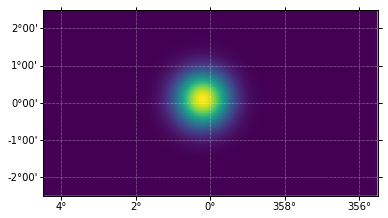

In [11]:
npred_map.sum_over_axes().plot()

In [12]:
# This one line is the core of how to simulate data when
# using binned simulation / analysis: you Poisson fluctuate
# npred to obtain simulated observed counts.
# Compute counts as a Poisson fluctuation
rng = np.random.RandomState()
counts = rng.poisson(npred)
counts_map = WcsNDMap(geom, counts)

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x116cd6390>)

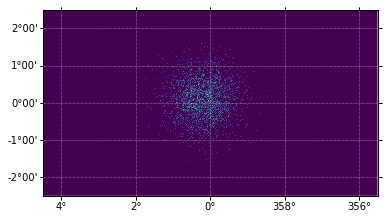

In [13]:
counts_map.sum_over_axes().plot()

## Fit

Now let's analyse the simulated data.
Here we just fit it again with the same model we had before, but you could do any analysis you like here, e.g. fit a different model, or do a region-based analysis, ...

In [14]:
# Define sky model to fit the data
spatial_model = SkyGaussian(
    lon_0='0 deg',
    lat_0='0 deg',
    sigma='1 deg',
)
spectral_model = PowerLaw(
    index=2,
    amplitude='1e-11 cm-2 s-1 TeV-1',
    reference='1 TeV',
)
model = SkyModel(
    spatial_model=spatial_model,
    spectral_model=spectral_model,
)

model.parameters.set_parameter_errors({
    'lon_0': '0.1 deg',
    'lat_0': '0.1 deg',
    'sigma': '0.1 deg',
    'index': '0.1',
    'amplitude': '1e-12 cm-2 s-1 TeV-1',
})

model.parameters['sigma'].parmin = 0

In [15]:
fit = SkyModelMapFit(
    model=model.copy(),
    counts=counts_map,
    exposure=exposure_map,
)

fit.fit()

/Users/deil/code/gammapy/gammapy/utils/fitting/iminuit.py:44: InitialParamWarning: errordef is not given. Default to 1.
  **minuit_kwargs)


FCN = 27335.15666238505 
 TOTAL NCALL = 179 
 NCALLS = 179 
 
 
 EDM = 2.3596415502756215e-06 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,lon_0,0.19712,0.00804311,0,0,,,
2,lat_0,0.109763,0.00802992,0,0,,,
3,sigma,0.497804,0.00407056,0,0,0.0,,
4,index,2.96981,0.0205693,0,0,,,
5,amplitude,1.04443e-11,3.43293e-13,0,0,,,
6,reference,1,0,0,0,,,FIXED


In [16]:
print('Start values:\n\n{}\n\n'.format(model.parameters))
print('Fit result:\n\n{}\n\n'.format(fit.model.parameters))

# TODO: 
# print('True values\n{}'.format(get_sky_model().parameters))

Start values:

ParameterList
Parameter(name='lon_0', value=0.0, unit='deg', min=nan, max=nan, frozen=False)
Parameter(name='lat_0', value=0.0, unit='deg', min=nan, max=nan, frozen=False)
Parameter(name='sigma', value=1.0, unit='deg', min=0, max=nan, frozen=False)
Parameter(name='index', value=2, unit='', min=nan, max=nan, frozen=False)
Parameter(name='amplitude', value=1e-11, unit='1 / (cm2 s TeV)', min=nan, max=nan, frozen=False)
Parameter(name='reference', value=1.0, unit='TeV', min=nan, max=nan, frozen=True)

Covariance: 
[[1.e-02 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]
 [0.e+00 1.e-02 0.e+00 0.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 1.e-02 0.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 1.e-02 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00 1.e-24 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]]


Fit result:

ParameterList
Parameter(name='lon_0', value=0.19711961887088114, unit='deg', min=nan, max=nan, frozen=False)
Parameter(name='lat_0', value=0.10976271184072822, unit='deg', min=nan, ma

In [17]:
# TODO: show e.g. how to make a residual image

## iminuit

What we have done for now is to write a very thin wrapper for http://iminuit.readthedocs.io/
as a fitting backend. This is just a prototype, we will improve this interface and
add other fitting backends (e.g. Sherpa or scipy.optimize or emcee or ...)

As a power-user, you can access ``fit.iminuit`` and get the full power of what is developed there already.
E.g. the ``fit.fit()`` call ran ``Minuit.migrad()`` and ``Minuit.hesse()`` in the background, and you have
access to e.g. the covariance matrix, or can check a likelihood profile, or can run ``Minuit.minos()``
to compute asymmetric errors or ...

In [18]:
# Check correlation between model parameters
# As expected in this simple case,
# spatial parameters are uncorrelated,
# but the spectral model amplitude and index are correlated as always
fit.minuit.print_matrix()

+,lon_0,lat_0,sigma,index,amplitude
lon_0,1.00,0.00,-0.03,-0.00,-0.01
lat_0,0.00,1.00,-0.02,-0.00,-0.01
sigma,-0.03,-0.02,1.00,0.00,0.01
index,-0.00,-0.00,0.00,1.00,-0.87
amplitude,-0.01,-0.01,0.01,-0.87,1.00


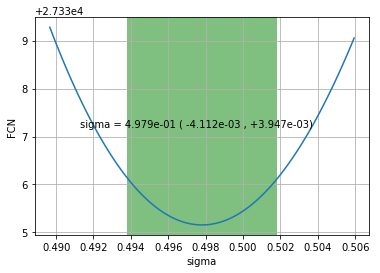

In [19]:
# You can use likelihood profiles to check if your model is
# well constrained or not, and if the fit really converged
fit.minuit.draw_profile('sigma');